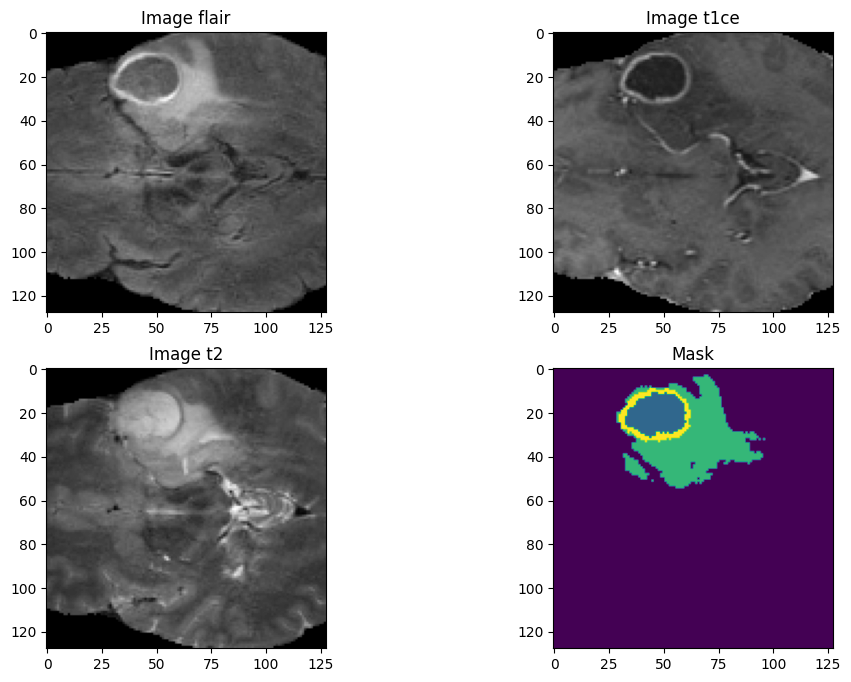

In [ ]:
import os
import numpy as np
from custom_datagen import imageLoader
import tensorflow as tf  # Use TensorFlow directly
import tensorflow.keras
from matplotlib import pyplot as plt
import os
import numpy as np
from custom_datagen import imageLoader
import tensorflow as tf
# import tensorflow.keras
from matplotlib import pyplot as plt
import glob
import random
import pandas as pd
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

import glob
import random
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
print(np.__version__)


In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive/my project")


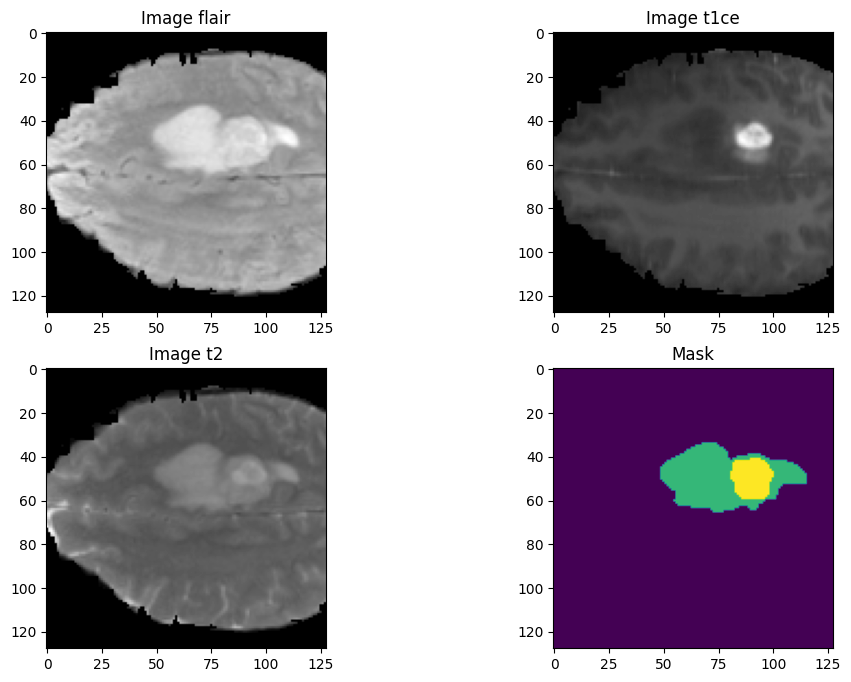

In [ ]:
train_img_dir = r"/content/drive/MyDrive/input_data_128/input_data_128/train/images/"
train_mask_dir = r"/content/drive/MyDrive/input_data_128/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
train_img_dir = r"/content/drive/MyDrive/input_data_128/input_data_128/train/images/"
train_mask_dir = r"/content/drive/MyDrive/input_data_128/input_data_128/train/masks/"


val_img_dir = r"/content/drive/MyDrive/input_data_128/input_data_128/val/images/"
val_mask_dir = r"/content/drive/MyDrive/input_data_128/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

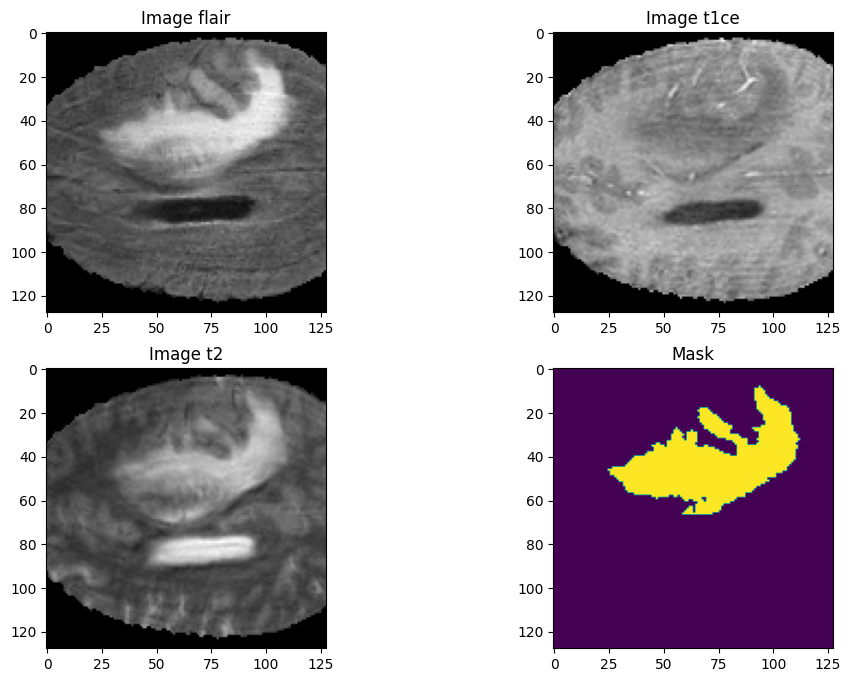

In [ ]:
########################################################################
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


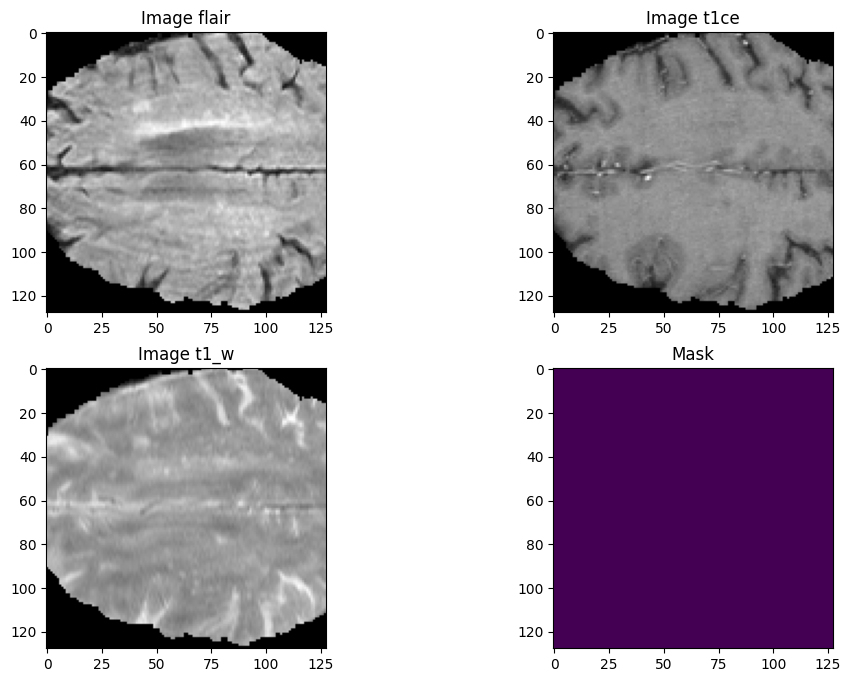

In [ ]:
train_img_dir = r"/content/drive/MyDrive/input_data_128/input_data_128/train/images/"
train_mask_dir = r"/content/drive/MyDrive/input_data_128/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t1_w')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from CNN_model import simple_unet_model

# Define loss, metrics, and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
# Define your custom loss function
def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - (2 * intersection + 1) / (union + 1)

def focal_loss(y_true, y_pred):
    alpha = 1
    gamma = 2
    ce = CategoricalCrossentropy()
    pt = tf.exp(-ce(y_true, y_pred))
    return alpha * (1 - pt) ** gamma * ce(y_true, y_pred)

def total_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)
    return dice + focal

# Define your custom accuracy metric
def custom_accuracy(y_true, y_pred):
    accuracy = CategoricalAccuracy()(y_true, y_pred)
    return accuracy

metrics = [custom_accuracy]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)


In [ ]:
# @tf.function
# def train_step(images, labels):
#     with tf.GradientTape() as tape:
#         predictions = model(images, training=True)
#         loss_value = total_loss(labels, predictions)
#     gradients = tape.gradient(loss_value, model.trainable_variables)
#     optim.apply_gradients(zip(gradients, model.trainable_variables))
#     return loss_value

# # Training loop
# for epoch in range(2):
#     start_time = time.time()
#     for step, (batch_images, batch_labels) in enumerate(train_img_datagen):
#         loss_value = train_step(batch_images, batch_labels)
#         if step % 10 == 0:
#             print(f"Epoch {epoch}, Step {step}, Loss: {loss_value.numpy()}")
#     elapsed_time = time.time() - start_time
#     print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, Time: {elapsed_time:.2f} seconds")


# # Save the model
# model.save('C:/files/Jupyter_version/models')

In [ ]:
import time
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU devices found. Please make sure TensorFlow is configured with GPU support.")


In [ ]:
################33 TEST THIS ONE <3333333333333

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from simple_3d_unet import simple_unet_model
# Define class weights
wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
class_weights = np.array([wt0, wt1, wt2, wt3])

# Define custom loss functions
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - tf.reduce_mean(numerator / denominator)

def categorical_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

    focal_loss = - alpha * (1 - y_pred) ** gamma * y_true * tf.math.log(y_pred)
    return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

# Combine losses
def total_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + 1.0 * categorical_focal_loss(y_true, y_pred)

# Define metrics
def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    iou = tf.reduce_mean((intersection + 1e-10) / (union + 1e-10))
    return iou

model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)


# Compile the model
LR = 0.0001
optim = keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optim, loss=total_loss, metrics=['accuracy', iou_score])

print(model.summary())

print(model.input_shape)
print(model.output_shape)
#####################################33&&&
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

all_layers = model.layers

    # Filter out custom layers
custom_layers = [layer for layer in all_layers if not isinstance(layer, type(tf.keras.layers.Layer))]

    # Print information about custom layers
if custom_layers:
    print("Custom Layers:")
    for layer in custom_layers:
        print(f"- {layer.name}: {type(layer)}")
else:
    print("No custom layers found.")



history=model.fit(train_img_datagen,
          steps_per_epoch=100,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('model_3d_v1.hdf5')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_1[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 128,  │              0 │ conv3d_19[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_9[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 64, 64, 64, 16) │              0 │ conv3d_20[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_21 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_22 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 32, 32, 32, 32) │              0 │ conv3d_22[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_24 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_6           │ (None, 16, 16, 16, 64) │              0 │ conv3d_24[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_25 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_6[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_25[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_1[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 128,  │              0 │ conv3d_19[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_9[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 64, 64, 64, 16) │              0 │ conv3d_20[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_21 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_22 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 32, 32, 32, 32) │              0 │ conv3d_22[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_24 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_6           │ (None, 16, 16, 16, 64) │              0 │ conv3d_24[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_25 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_6[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_25[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)
Custom Layers:
- input_layer_1: <class 'keras.src.layers.core.input_layer.InputLayer'>
- conv3d_19: <class 'keras.src.layers.convolutional.conv3d.Conv3D'>
- dropout_9: <class 'keras.src.layers.regularization.dropout.Dropout'>
- conv3d_20: <class 'keras.src.layers.convolutional.conv3d.Conv3D'>
- max_pooling3d_4: <class 'keras.src.layers.pooling.max_pooling3d.MaxPooling3D'>
- conv3d_21: <class 'keras.src.layers.convolutional.conv3d.Conv3D'>
- dropout_10: <class 'keras.src.layers.regularization.dropout.Dropout'>
- conv3d_22: <class 'keras.src.layers.convolutional.conv3d.Conv3D'>
- max_pooling3d_5: <class 'keras.src.layers.pooling.max_pooling3d.MaxPooling3D'>
- conv3d_23: <class 'keras.src.layers.convolutional.conv3d.Conv3D'>
- dropout_11: <class 'keras.src.layers.regularization.dropout.Dropout'>
- conv3d_24: <class 'keras.src.layers.convolutional.conv3d.Conv3D'>
- max_pooling3d_6: <class 'keras.src.layers.pooling.max_pooling3d.MaxPool

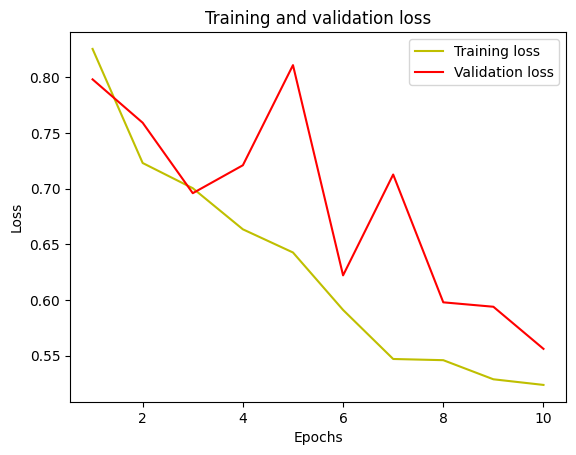

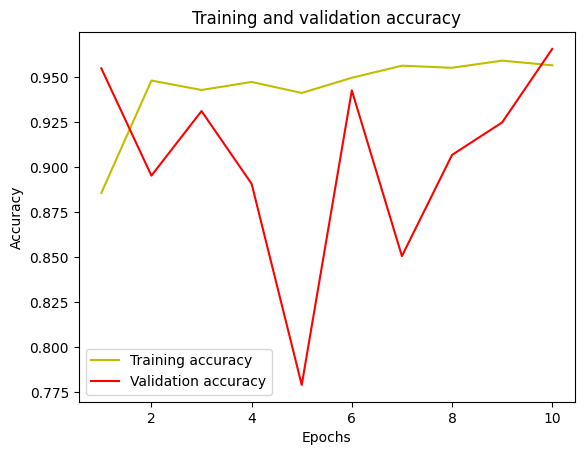

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

#For predictions you do not need to compile the model, so ...
my_model = load_model('/content/model_3d_v1.hdf5',
                      compile=False)


#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step
Mean IoU = 0.4383772


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


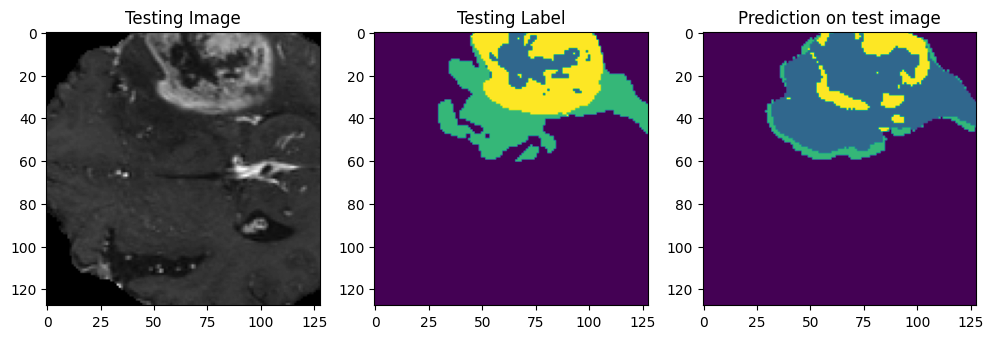

In [ ]:

#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = 110

test_img = np.load("/content/drive/MyDrive/input_data_128/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/input_data_128/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

############################################################
